In [2]:
!pip install -qq -U diffusers datasets transformers accelerate ftfy
!pip install -qq wandb
!pip install -qq torchinfo
!pip install -qq matplotlib

In [3]:
from huggingface_hub import notebook_login
from datasets import load_dataset
import wandb
import torch
from diffusers import DDPMScheduler, UNet2DModel, DDPMPipeline
from pathlib import Path


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im

https://huggingface.co/settings/tokens

In [5]:
notebook_login()

In [ ]:
dataset = load_dataset('matteopilotto/pokemon_cute')

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1453
    })
})

In [8]:
PROJECT_NAME = "sd-pokemon-icons"
MODEL_NAME = "sd-pokemon-icons-64"

In [ ]:
!accelerate launch --mixed_precision=bf16 train_unconditional_v3.py \
    --project_name={PROJECT_NAME} \
    --ddpm_beta_schedule='squaredcos_cap_v2' \
    --dataset_name='matteopilotto/pokemon_cute' \
    --dataset_sample_size=1453 \
    --seed=2077 \
    --resolution=64 \
    --output_dir={MODEL_NAME} \
    --train_batch_size=64 \
    --eval_batch_size=4 \
    --num_epochs=100 \
    --gradient_accumulation_steps=1 \
    --learning_rate=4e-4 \
    --lr_scheduler="cosine" \
    --lr_warmup_steps=500 \
    --dataloader_num_workers=12 \
    --mixed_precision="bf16"

In [ ]:
# SAVE MODEL'S CHECKPOINT ON WANDB 

# ref: https://docs.wandb.ai/guides/track/advanced/resuming
# ref: https://docs.wandb.ai/ref/python/artifact

RUN_ID = '1o7lzcq4'
MODEL_PATH = f'./{MODEL_NAME}'

with wandb.init(project=PROJECT_NAME, id=RUN_ID, resume=True) as run:
    artifact = wandb.Artifact(RUN_ID, type='model')
    artifact.add_dir(MODEL_PATH)
    run.log_artifact(artifact)

In [ ]:
# DOWNLOAD MODEL'S CHECKPOINT FROM WANDB

with wandb.init(project=PROJECT_NAME, id=RUN_ID, resume=True) as run:
    artifact = wandb.use_artifact(f'matt24/sd-pokemon-icons/{RUN_ID}:v0', type='model')
    artifact_dir = artifact.download()

print(artifact_dir)

In [23]:
# LOAD MODEL'S CHECKPOINT IN THE GENERATIVE PIPELINE

ckpt = Path(artifact_dir)

model = UNet2DModel.from_pretrained(pretrained_model_name_or_path=ckpt/'unet')
noise_scheduler = DDPMScheduler.from_pretrained(pretrained_model_name_or_path=ckpt/'scheduler')
pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler).to(device)

  0%|          | 0/1000 [00:00<?, ?it/s]

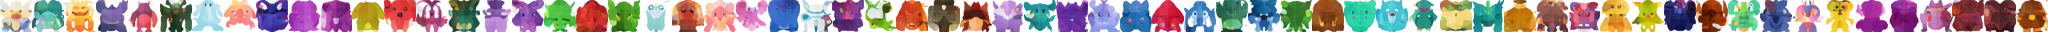

In [24]:
from PIL import Image
generator = torch.Generator(device=pipeline.device).manual_seed(0)
images = pipeline(batch_size=64, generator=generator).images
make_grid(images, size=32)

In [25]:
with wandb.init(project=PROJECT_NAME, id=RUN_ID, resume=True) as run:
    run.log({"Generated images": [wandb.Image(image) for image in images]})

ema_decay,0.99699
loss,0.0195
lr,0
step,2300
